# Naver 영화 리뷰 감정분석
데이터 셋은 https://github.com/e9t/nsmc 의 자료를 사용

In [45]:
import urllib.request
import pandas as pd

## data 가져오기
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="total_data.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="train_data.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="test_data.txt")

total_data = pd.read_table("total_data.txt")            # read_table시 자동으로 strip() 적용
train_data = pd.read_table("train_data.txt")
test_data = pd.read_table("test_data.txt")

print("총 데이터 개수: ", len(total_data))
print("훈련 데이터 개수:", len(train_data))
print("검증 데이터 개수:", len(test_data))

총 데이터 개수:  200000
훈련 데이터 개수: 150000
검증 데이터 개수: 50000


In [46]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


# 데이터 전처리 진행
데이터의 결측값, 이상값, 빈값, 중복 등을 처리하여 정제된 데이터 셋으로 구성

In [47]:
import pandas as pd

# 1. 정규표현식 적용
train_data["document"] = train_data['document'].str.replace("[^0-9^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True).str.replace("[ㄱ-ㅎㅏ-ㅣ]", "", regex=True).str.replace("^", "", regex=False)
test_data["document"] = test_data['document'].str.replace("[^0-9^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True).str.replace("[ㄱ-ㅎㅏ-ㅣ]", "", regex=True).str.replace("^", "", regex=False)

In [48]:
# Id 별 중복되는 document 확인 및 삭제
# 다만, id는 다르지만 중복된 리뷰라면 개개인의 의견이니 제거 하지 않는다.
train_data["id"].is_unique        # is_unique ; res => boolean True - 중복 없음 / False - 중복 있음  # True
test_data['id'].is_unique         # True

True

In [49]:
# 맞춤법 및 띄어쓰기 교정
import os.path
import pickle
import gzip
import os
import pandas as pd

from hanspell import spell_checker
from tqdm import tqdm

## train_data 진행
file = 'cor_train_data.txt'

if os.path.isfile(file):
    print(f'{file} 파일이 존재합니다. 불러옵니다.')
    with gzip.open('cor_train_data.txt', 'rb') as f:
        correction_train_document = pickle.load(f)
        train_data['document'] = pd.DataFrame(correction_train_document)
        print("파일을 불러왔습니다.")
else:
    correction_train_document = []
    for i in tqdm(range(train_data.shape[0])):
        try:
            cor_doc = spell_checker.check(train_data['document'][i])
            correction_train_document.append(cor_doc.checked)
        except:
            correction_train_document.append("")
        # 108분 소요
    
    # 생성된 리스트 파일로 저장
    with gzip.open("cor_train_data.txt", 'wb') as F:
        pickle.dump(correction_train_document, F, pickle.HIGHEST_PROTOCOL)
        print("파일을 생성하였습니다.")


train_data['document'] = pd.DataFrame(correction_train_document)

train_data

cor_train_data.txt 파일이 존재합니다. 불러옵니다.
파일을 불러왔습니다.


,id,document,label
0,9976970,아 더빙 진짜 짜증 나네요 목소리,0
1,3819312,흠포스터보고 초등학생영화 줄 오버 연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이먼 페그의 익살스러운 연기가 돋보였던 영화 스파이더맨에서 늙어 보이기만 했던 커...,1
...,...,...,...
149995,6222902,인간이 문제지 소는 뭔 죄인가,0
149996,8549745,평점이 너무 낮아서,1
149997,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0
149998,2376369,청춘 영화의 최고봉 방황과 우울했던 날들의 자화상,1


In [50]:
# 맞춤법 교정 - 계속
## test_data 진행
file = 'cor_test_data.txt'

if os.path.isfile(file):
    print(f'{file} 파일이 존재합니다. 불러옵니다.')
    with gzip.open('cor_test_data.txt', 'rb') as f:
        correction_test_document = pickle.load(f)
        test_data['document'] = pd.DataFrame(correction_test_document)
        print("파일을 불러왔습니다.")
else:
    correction_test_document = []
    for i in tqdm(range(test_data.shape[0])):
        try:
            cor_doc = spell_checker.check(test_data['document'][i])
            correction_test_document.append(cor_doc.checked)
        except:
            correction_test_document.append("")
        # 35분 소요

    # 생성된 리스트 파일로 저장
    with gzip.open("cor_test_data.txt", 'wb') as F:
        pickle.dump(correction_test_document, F, pickle.HIGHEST_PROTOCOL)
        print("파일을 생성하였습니다.")


test_data['document'] = pd.DataFrame(correction_test_document)

cor_test_data.txt 파일이 존재합니다. 불러옵니다.
파일을 불러왔습니다.


In [51]:
# 결측값(NaN, Null) 제거
train_data.dropna(inplace = True)
test_data.dropna(inplace = True)

In [52]:
# 빈값 확인 
train_drop = [ i for i, v in enumerate(train_data['document']) if str(v).strip() == "" ]
test_drop = [ i for i, v in enumerate(test_data['document']) if str(v).strip() == "" ]

train_data.loc[train_data.index[train_drop]]

,id,document,label
404,4221289,,0
412,9509970,,1
470,10147571,,1
668,1600635,,0
972,7425748,,0
...,...,...,...
149445,7133917,,0
149630,3508604,,0
149718,7690797,,1
149773,9233162,,0


In [53]:
# 빈값 제거
train_data.drop(train_drop, inplace=True)
test_data.drop(test_drop, inplace=True)

# 인덱스 재정렬
train_data.reset_index(drop=True,  inplace=True)
test_data.reset_index(drop=True, inplace=True)

In [54]:
train_data

,id,document,label
0,9976970,아 더빙 진짜 짜증 나네요 목소리,0
1,3819312,흠포스터보고 초등학생영화 줄 오버 연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이먼 페그의 익살스러운 연기가 돋보였던 영화 스파이더맨에서 늙어 보이기만 했던 커...,1
...,...,...,...
148527,6222902,인간이 문제지 소는 뭔 죄인가,0
148528,8549745,평점이 너무 낮아서,1
148529,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0
148530,2376369,청춘 영화의 최고봉 방황과 우울했던 날들의 자화상,1


# 3. 데이터 코드화

(LSTM 분석을 위해서는 벡터화된 데이터셋이 필요함.)</br>
토큰화는 Kkma, Komoran 두가지로 테스트 예정</br>
둘 중 프로젝트에 더 적합한 모습을 보이는 라이브러리로 진행을 위한 테스트


In [55]:
import jpype

from konlpy.tag import Kkma, Hannanum, Komoran, Okt

Kkma = Kkma()
Komoran = Komoran()
Okt = Okt()
Hannanum = Hannanum()

for i in range(4):
    print("="*100)
    print(train_data['document'][i])
    print("Kkma", Kkma.morphs(train_data['document'][i]))
    print("Komran",Komoran.morphs(train_data['document'][i]))
    print("Okt", Okt.morphs(train_data['document'][i], norm=True))   # norm: 정규화 처리 / stem: 각 단어에서 어간을 추출
    print("Hannanum", Hannanum.morphs(train_data['document'][i]))

아 더빙 진짜 짜증 나네요 목소리
Kkma ['아', '아', '더빙', '진짜', '짜증', '나', '네요', '목소리']
Komran ['아', '더빙', '진짜', '짜증', '나', '네요', '목소리']
Okt ['아', '더빙', '진짜', '짜증', '나네요', '목소리']
Hannanum ['아', '더빙', '진짜', '짜증', '나', '이', '네', '요', '목소리']
흠포스터보고 초등학생영화 줄 오버 연기조차 가볍지 않구나
Kkma ['흠', '포스터', '보고', '초등학생', '영화', '줄', '오버', '연기', '조차', '가볍', '지', '않', '구나']
Komran ['흠', '포스터', '보고', '초등학생', '영화', '주', 'ㄹ', '오버', '연기', '조차', '가볍', '지', '않', '구나']
Okt ['흠', '포스터', '보고', '초등학생', '영화', '줄', '오버', '연기', '조차', '가볍지', '않구나']
Hannanum ['흠포스터보', '이', '고', '초등학생영화', '주', 'ㄹ', '오버', '연기', '조차', '가볍', '지', '않', '구나']
너무재밓었다그래서보는것을추천한다
Kkma ['너무', '재', '밓', '어', '었', '다', '그래서', '보', '는', '것', '을', '추천', '하', 'ㄴ다']
Komran ['너무재밓었다그래서보는것을추천한다']
Okt ['너', '무재', '밓었', '다그', '래서', '보는것을', '추천', '한', '다']
Hannanum ['너무재밓었다그래서보는것을추천한다']
교도소 이야기구먼 솔직히 재미는 없다 평점 조정
Kkma ['교도소', '이야기', '구', '멀', 'ㄴ', '솔직히', '재미', '는', '없', '다', '평점', '조정']
Komran ['교도소', '이야기', '이', '구먼', '솔직히', '재미', '는', '없', '다', '평점', '조정']
Okt ['교도소', '이야기',

## 문장 → 단어로 분할[리스트] / 불용어 사전 제작

In [56]:
import jpype
from konlpy.tag import Komoran
from tqdm import tqdm


# tagged_train_data 생성 or 불러오기
file = 'tagged_train_data.txt'

if os.path.isfile(file):
    print('파일이 존재합니다. 불러옵니다')
    with open('tagged_train_data.txt', 'rb') as f:
        tagged_train_data = pickle.load(f)
        print("불러오기 완료.")
else:
    stopwords = ['의','가','이','은','들','는','걍','과', '의', '도','을', '것', '를','으로','자','에','와','한','하다',
             'ㄴ', '다','에서', '하는', '나', '자', '고', '이다','수','데','인데','너무','정말','거','한','점','로']

    # 품사 태깅
    tagged_train_data = []
    train_error_sentence = []

    Komoran = Komoran()
    for i in tqdm(range(train_data.shape[0])):
        try:
            temp_x = Komoran.morphs(train_data['document'][i])                        # 토큰화
            temp_x = [word for word in temp_x if not word in stopwords]             # 불용어 제거
            tagged_train_data.append(temp_x)
        except:
            tagged_train_data.append([])
            train_error_sentence.append(i)
            
    print("훈련데이터 에러 발생 수:", len(train_error_sentence))
        
    with open("tagged_train_data.txt", 'wb') as F:
        pickle.dump(tagged_train_data, F, pickle.HIGHEST_PROTOCOL)
        print("파일을 생성하였습니다.")

파일이 존재합니다. 불러옵니다
불러오기 완료.


In [57]:
# 품사 태깅 - 계속
# tagged_test_data 저장
file = 'tagged_test_data.txt'

if os.path.isfile(file):
    print('파일이 존재합니다. 불러옵니다')
    with open('tagged_test_data.txt', 'rb') as f:
        tagged_test_data = pickle.load(f)
        print("불러오기 완료.")
else:
    tagged_test_data = []
    test_error_sentence = []
    
    Komoran = Komoran()
    for i in tqdm(range(test_data.shape[0])):
        try:
            temp_x = Komoran.morphs(test_data['document'][i])                 # 토큰화
            temp_x = [word for word in temp_x if not word in stopwords]           # 불용어 제거
            tagged_test_data.append(temp_x)
        except:
            tagged_test_data.append([])
            test_error_sentence.append(i)

    print("훈련데이터 에러 발생 수:", len(test_error_sentence))

    with open("tagged_test_data.txt", 'wb') as F:
        pickle.dump(tagged_test_data, F, pickle.HIGHEST_PROTOCOL)
        print("파일을 생성하였습니다.")

파일이 존재합니다. 불러옵니다
불러오기 완료.


In [58]:
len(tagged_train_data)

148532

# 기계가 텍스트를 숫자로 처리할 수 있도록 정수 인코딩을 진행
<br>
다만 태깅한 품사를 모두 사용해서 학습한다면, 1, 2회 사용된 <br>
즉 너무 적은 단위로 사용된 단어들까지 학습된다. <br>
하면 데이터 분석에 효율성이 떨어질 수 있다. (혹은 과적합)<br>
하여 자주 사용된 단어(3회 이상)만 추려서 인공신경망 학습에 사용될 수 있도록<br>
3회 이하 사용된 단어들은 제거 한다. 

#### 3회 이하로 사용된 단어들이 얼마나 있는지 확인.

In [59]:
# 우선 정수 인코딩 진행
import tensorflow
from keras.preprocessing.text import Tokenizer

tokenizer_maxlen = Tokenizer()
tokenizer_maxlen.fit_on_texts(tagged_train_data)

print(tokenizer_maxlen.word_index)  # word_index => {'하': 1, 'ㄴ': 2, '영화': 3, '다': 4, '고': 5, ... ✨자주 사용된 단어가 먼저 나열
                                    # word_counts => OrderedDict([('아', 154), ('더빙', 5), ('진짜', 69) ...
                                    # word_docs => defaultdict(<class 'int'>, {'목소리': 2, '짜증나': 8, ...


{'하': 1, '영화': 2, '보': 3, '았': 4, 'ㄹ': 5, '게': 6, '었': 7, '지': 8, '어': 9, '아': 10, '있': 11, '없': 12, 'ㅁ': 13, '되': 14, '주': 15, '는데': 16, '좋': 17, '만': 18, '재밌': 19, '기': 20, '안': 21, '적': 22, '음': 23, '어요': 24, '네요': 25, '네': 26, 'ㄴ다': 27, '같': 28, '진짜': 29, '지만': 30, '아니': 31, '만들': 32, '않': 33, '아서': 34, '말': 35, '연기': 36, '면': 37, '내': 38, '나오': 39, '최고': 40, 'ㅂ니다': 41, '잘': 42, '평점': 43, '뭐': 44, '겠': 45, '이런': 46, '던': 47, '왜': 48, '습니다': 49, '시': 50, '스토리': 51, '생각': 52, '그': 53, '때': 54, '드라마': 55, '1': 56, '보다': 57, '사람': 58, '듯': 59, '감동': 60, '배우': 61, '걸': 62, '그냥': 63, '더': 64, '까지': 65, '싶': 66, '어서': 67, '아깝': 68, '재미있': 69, '오': 70, '알': 71, '좀': 72, '내용': 73, '감독': 74, '재미없': 75, 'ㄴ데': 76, '중': 77, '시간': 78, '라': 79, '지루': 80, '아도': 81, '쓰레기': 82, '요': 83, '이렇': 84, '이것': 85, '냐': 86, 'ㄴ가': 87, '재미': 88, '번': 89, '라고': 90, '10': 91, '모르': 92, '다시': 93, '면서': 94, '으면': 95, '보이': 96, '작품': 97, '개': 98, '못하': 99, '야': 100, '건': 101, '사랑': 102, '남': 103, '정도': 104, '마지막': 

In [60]:
threshold = 4
total_cnt = len(tokenizer_maxlen.word_index)                # 모든 토큰의 수
rare_cnt = 0                                                # 3번 이하 등장 단어 개수
total_freq = 0                                              # 토근화된 단어의 총합
rare_freq = 0                                               # 토근화된 단어 중 3번 이하 사용된 단어의 총합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer_maxlen.word_counts.items():       # word_counts: 해당 단어의 빈도수를 반환
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if value < threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('등장 빈도가 2번 이하인 희귀 단어의 수:', rare_cnt)
print("전체 품사 집합에서 2회 이하 사용된 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

등장 빈도가 2번 이하인 희귀 단어의 수: 22553
전체 품사 집합에서 2회 이하 사용된 단어의 비율: 60.502736345101404
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.7015071742979961


In [61]:
# 0번 패딩 토큰을 고려하여 + 1 / max-embadding_number(voca_size) 설정

voca_size = total_cnt - rare_cnt + 1
print(f'즉, 총 단어의 수는 {total_cnt}개 / 그 중 2회 이하 사용된 단어의 수는 {rare_cnt}')
print("2회 이하 사용된 단어를 제거한 == 남길 단어(Embedding)의 사이즈:", voca_size - 1)

즉, 총 단어의 수는 37276개 / 그 중 2회 이하 사용된 단어의 수는 22553
2회 이하 사용된 단어를 제거한 == 남길 단어(Embedding)의 사이즈: 14723


In [62]:
tokenizer = Tokenizer(num_words=voca_size)                           # Tokenizer(voca_size) => 토근화 진행하면서 max_embadding(100, 12, 4 ...)를 설정
# 학습 데이터 
tokenizer.fit_on_texts(tagged_train_data)                            # fit_on_texts => Updates internal vocabulary based on a list of texts.
enbadded_train_data = tokenizer.texts_to_sequences(tagged_train_data)    # texts_to_sequences => Transforms each text in texts to a sequence of integers.

# 검증 데이터 
tokenizer.fit_on_texts(tagged_test_data)                             # fit_on_texts => Updates internal vocabulary based on a list of texts.
embadded_test_data = tokenizer.texts_to_sequences(tagged_test_data)

len(enbadded_train_data)

148532

In [63]:
# 테스트를 위해 데이터 분리 및 임베딩 데이터 추가
embadding_train_data = train_data
embadding_test_data = test_data

embadding_train_data.insert(train_data.shape[1], "token", enbadded_train_data)
embadding_test_data.insert(test_data.shape[1], "token", embadded_test_data)

In [64]:
embadding_train_data

,id,document,label,token
0,9976970,아 더빙 진짜 짜증 나네요 목소리,0,"[10, 466, 29, 174, 25, 683]"
1,3819312,흠포스터보고 초등학생영화 줄 오버 연기조차 가볍지 않구나,1,"[999, 509, 1582, 493, 2, 15, 5, 957, 36, 779, ..."
2,10265843,너무재밓었다그래서보는것을추천한다,0,[]
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0,"[5897, 139, 487, 253, 88, 12, 43, 3261]"
4,6483659,사이먼 페그의 익살스러운 연기가 돋보였던 영화 스파이더맨에서 늙어 보이기만 했던 커...,1,"[7401, 113, 36, 817, 7, 47, 2, 2844, 1076, 9, ..."
...,...,...,...,...
148527,6222902,인간이 문제지 소는 뭔 죄인가,0,"[239, 461, 8, 795, 44, 1132, 87]"
148528,8549745,평점이 너무 낮아서,1,"[43, 210, 34]"
148529,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0,"[6, 44, 83, 1336, 9528, 9477, 1034]"
148530,2376369,청춘 영화의 최고봉 방황과 우울했던 날들의 자화상,1,"[9621, 2095, 2697, 1056, 1, 4, 47, 449, 7145]"


In [65]:
# 빈 리스트 행 확인
train_drop = [i for i, v in enumerate(embadding_train_data['token']) if v == []]
test_drop = [i for i, v in enumerate(embadding_test_data['token']) if v == []]

print('비어있는 행의 수 :', len(train_drop))

비어있는 행의 수 : 647


In [66]:
len(train_drop)

647

In [67]:
# 빈 리스트 행 제거 및 확인
embadding_train_data.drop(train_drop, inplace=True)
embadding_test_data.drop(test_drop, inplace=True)

# 인덱스 초기화
embadding_train_data.reset_index(drop=True, inplace=True)
embadding_test_data.reset_index(drop=True, inplace=True)


In [68]:
embadding_train_data

,id,document,label,token
0,9976970,아 더빙 진짜 짜증 나네요 목소리,0,"[10, 466, 29, 174, 25, 683]"
1,3819312,흠포스터보고 초등학생영화 줄 오버 연기조차 가볍지 않구나,1,"[999, 509, 1582, 493, 2, 15, 5, 957, 36, 779, ..."
2,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0,"[5897, 139, 487, 253, 88, 12, 43, 3261]"
3,6483659,사이먼 페그의 익살스러운 연기가 돋보였던 영화 스파이더맨에서 늙어 보이기만 했던 커...,1,"[7401, 113, 36, 817, 7, 47, 2, 2844, 1076, 9, ..."
4,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살 용 영화 별 반 개도 아까움,0,"[566, 1233, 131, 194, 150, 1590, 56, 1380, 552..."
...,...,...,...,...
147880,6222902,인간이 문제지 소는 뭔 죄인가,0,"[239, 461, 8, 795, 44, 1132, 87]"
147881,8549745,평점이 너무 낮아서,1,"[43, 210, 34]"
147882,9311800,이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다,0,"[6, 44, 83, 1336, 9528, 9477, 1034]"
147883,2376369,청춘 영화의 최고봉 방황과 우울했던 날들의 자화상,1,"[9621, 2095, 2697, 1056, 1, 4, 47, 449, 7145]"


# 모델 학습을 위한 sequence padding 진행

리뷰의 최대 길이 : 94
리뷰의 평균 길이 : 12.905156033404335


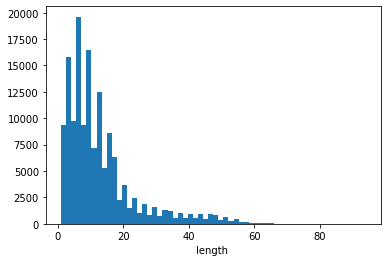

In [69]:
print('리뷰의 최대 길이 :',max(len(l) for l in embadding_train_data["token"]))
print('리뷰의 평균 길이 :',sum(map(len, embadding_train_data["token"]))/len(embadding_train_data["token"]))

import matplotlib.pyplot as plt
plt.hist([len(s) for s in embadding_train_data["token"]], bins=60)
plt.xlabel('length ')
plt.show()

In [70]:
def belong(max_len, nested_list):
    global optimize
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
        if (cnt / len(nested_list))*100 <= 98:
            optimize = int((cnt / len(nested_list))*100)
    print(f'전체 샘플 중 길이가 {max_len} 이하인 샘플의 비율: {(cnt / len(nested_list))*100}')

optimize = 100
for max_len in range(30, 60, 5):
    belong(max_len, embadding_train_data["token"])


전체 샘플 중 길이가 30 이하인 샘플의 비율: 91.58062007641072
전체 샘플 중 길이가 35 이하인 샘플의 비율: 93.76001622882644
전체 샘플 중 길이가 40 이하인 샘플의 비율: 95.52219630117997
전체 샘플 중 길이가 45 이하인 샘플의 비율: 97.18632721371337
전체 샘플 중 길이가 50 이하인 샘플의 비율: 98.62528315921155
전체 샘플 중 길이가 55 이하인 샘플의 비율: 99.5050207931839


## padding 길이 설정 후 => 훈련 데이터 / 검증 데이터 생성

In [85]:
from keras.preprocessing import sequence

train_x = sequence.pad_sequences(embadding_train_data['token'], maxlen=optimize)
train_label = embadding_train_data['label'].to_numpy()

test_x = sequence.pad_sequences(embadding_test_data['token'], maxlen=optimize)
test_label = embadding_test_data['label'].to_numpy()

In [90]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Embedding(voca_size, 100))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_x, train_label, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1970/1972 [============================>.] - ETA: 0s - loss: 0.3734 - acc: 0.8332- ETA: 1s - loss: 0
Epoch 00001: val_acc improved from -inf to 0.85377, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets
1972/1972 [==============================] - 177s 90ms/step - loss: 0.3734 - acc: 0.8331 - val_loss: 0.3407 - val_acc: 0.8538
Epoch 2/15
1970/1972 [============================>.] - ETA: 0s - loss: 0.2904 - acc: 0.8771
Epoch 00002: val_acc improved from 0.85377 to 0.86138, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets
1972/1972 [==============================] - 117s 60ms/step - loss: 0.2905 - acc: 0.8770 - val_loss: 0.3231 - val_acc: 0.8614
Epoch 3/15
1971/1972 [============================>.] - ETA: 0s - loss: 0.2440 - acc: 0.8999
Epoch 00003: val_acc improved from 0.86138 to 0.86236, saving model to best_model
INFO:tensorflow:Assets written to: best_model\assets
1972/1972 [==============================] - 107

In [91]:
loaded_model = load_model('best_model')
print(f"테스트 정확도: {loaded_model.evaluate(test_x, test_label)[1]}")

1540/1540 [==============================] - 10s 7ms/step - loss: 0.9756 - acc: 0.6073

 테스트 정확도: 0.6073378324508667
